In [1]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt

In [2]:
# Loading an image and converting colour space while accounting for bgr in jupyter
frame = cv2.imread('./test_images/jason_momoa.png')
display_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
display_copy = display_frame.copy()
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
rows, columns, _ = np.shape(frame)
data_type = frame.dtype

whiskers = cv2.imread('./filters/whiskers.png', cv2.IMREAD_UNCHANGED)
whisker_rows, whisker_columns, depth = np.shape(whiskers)

filter_layer = np.zeros((rows, columns, depth), data_type)

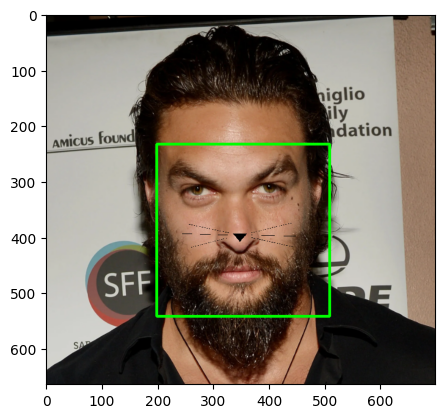

In [3]:
# Initialize dlib's face detector
detector = dlib.get_frontal_face_detector()

# Detect faces in the grayscale image
faces = detector(gray_frame)

# Find boundaries and draw bounding box
face = faces[0]
x1 = face.left()
y1 = face.top()
x2 = face.right()
y2 = face.bottom()

# Drawing a rectangle around the face
border_colour = (0,255,0)
border_width = 3
cv2.rectangle(display_frame, (x1,y1), (x2,y2), border_colour, border_width)

# Find landmarks
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
landmarks = predictor(gray_frame, face)
nosetip = (landmarks.part(30).x, landmarks.part(30).y)
noseleft = (landmarks.part(31).x, landmarks.part(31).y)
noseright = (landmarks.part(35).x, landmarks.part(35).y)
nose_width = abs(noseleft[0] - noseright[0])

# Adjust overlay
whisker_width = int(4 * nose_width)
whisker_height = int((whisker_rows / whisker_columns) * whisker_width)
half_height = whisker_height // 2
half_width = whisker_width // 2

resized_whiskers = cv2.resize(whiskers, (whisker_width, whisker_height))

filter_layer[nosetip[1] - half_height : nosetip[1] + half_height, nosetip[0] - half_width : nosetip[0] + half_width] = resized_whiskers

# Create mask from resized overlay and extract rgb channels
alpha_channel = filter_layer[:, :, 3] // 255
inverse_alpha_channel = np.bitwise_not(alpha_channel) // 255

overlay_colors = filter_layer[:, :, :3]
display_whiskers = cv2.cvtColor(overlay_colors, cv2.COLOR_BGR2RGB)

# Apply masks to images
masked_whiskers = cv2.bitwise_and(display_whiskers, display_whiskers, mask = alpha_channel)
masked_frame = cv2.bitwise_and(display_frame, display_frame, mask = inverse_alpha_channel)

# Add the images 
final_frame = cv2.add(masked_frame, masked_whiskers)

plt.imshow(masked_frame)
plt.show()